In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
import os
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image


from sklearn import *
from sklearn.utils import shuffle
import cv2
from sklearn.metrics import classification_report,plot_confusion_matrix,confusion_matrix,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay,precision_recall_curve,PrecisionRecallDisplay

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
import tensorflow as tf
from tensorflow import *
import albumentations as A
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import VGG16,EfficientNetB0,EfficientNetB1
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
!pip install split_folders
import splitfolders
image_path=Path('../input/chest-xray-pneumonia/chest_xray/train/')
splitfolders.ratio(image_path, output="output", seed=101, ratio=(.8, .1, .1))

Copying files: 5216 files [00:41, 126.45 files/s]


In [3]:
size_img=224
def img_Generator(file_name,gen_type):
    if gen_type=='yes':
        generet_Data=ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
        gen_data=generet_Data.flow_from_directory(file_name,target_size=(size_img, size_img),
                                                  batch_size=64,shuffle=True,
                                                  class_mode='binary')
                
    else:
        generet_Data1=ImageDataGenerator()
        gen_data=generet_Data1.flow_from_directory(file_name,target_size=(size_img, size_img),
                                                  batch_size=64,shuffle=False,
                                                  class_mode='binary')
    
    return gen_data

data_typ='yes'
train_data=img_Generator('./output/train/',data_typ)
data_typ='no'
test_data=img_Generator('./output/test/',data_typ)
data_typ='no'
val_data=img_Generator('./output/val/',data_typ)

Found 4172 images belonging to 2 classes.
Found 523 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


In [4]:
model = EfficientNetB1(
      input_shape = (size_img, size_img,3),
      include_top = False,
      weights = 'imagenet'
    )
mdl=model.output
mdl=GlobalAveragePooling2D()(mdl)
mdl=Flatten()(mdl)
mdl=Dropout(0.5)(mdl)
mdl=Dense(1,activation = "sigmoid")(mdl)
model=keras.Model(model.input,mdl)


model.compile(loss = "binary_crossentropy", 
              optimizer = "adam", 
              metrics = "accuracy")

tensorboard = TensorBoard(log_dir="logs")

early_stp=EarlyStopping(monitor='val_accuracy',
                        mode='max', 
                        verbose=1, 
                        patience=20)
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_accuracy', 
                             mode='Auto',
                             verbose=1,
                             save_best_only=True )

reduce_LR = ReduceLROnPlateau(monitor="val_accuracy", 
                             factor = 0.3, 
                             patience = 2, 
                             min_delta=0.001, 
                             mode = "auto", 
                            verbose = 1)

History = model.fit_generator(train_data,
                              validation_data=val_data,
                              epochs=15,verbose=1,
                              callbacks=[checkpoint,early_stp,tensorboard,reduce_LR])

27033600/27018416 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/15
66/66 [==============================] - 131s 2s/step - loss: 0.1843 - accuracy: 0.9238 - val_loss: 0.1216 - val_accuracy: 0.9712

Epoch 00001: val_accuracy improved from -inf to 0.97121, saving model to model.h5
Epoch 2/15
66/66 [==============================] - 108s 2s/step - loss: 0.1054 - accuracy: 0.9583 - val_loss: 0.1076 - val_accuracy: 0.9597

Epoch 00002: val_accuracy did not improve from 0.97121
Epoch 3/15
66/66 [==============================] - 107s 2s/step - loss: 0.0669 - accuracy: 0.9758 - val_loss: 0.0351 - val_accuracy: 0.9885

Epoch 00003: val_accuracy improved from 0.97121 to 0.98848, saving model to model.h5
Epoch 4/15
66/66 [==============================] - 107s 2s/step - loss: 0.0669 - accuracy: 0.9741 - val_loss: 0.0423 - val_accuracy: 0.9866

Epoch 00004: val_accuracy did not improve from 0.98848
Epoch 5/15
66/66 [==============================] - 108s 2s/step - loss: 0.0655 - accuracy: 0.9760 - val_loss: 0.0476 - val_accuracy: 0.9846

Epoch 00005: 

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
Finally plotting confusion matrix and others reports.
</p>
</div>

In [5]:
model.evaluate(test_data)

9/9 [==============================] - 6s 566ms/step - loss: 0.2664 - accuracy: 0.9331


[0.26638391613960266, 0.933078408241272]

In [6]:
data_sh=pd.DataFrame()
data_sh['Train_loss']=History.history['loss']
data_sh['Train_accuracy']=History.history['accuracy']
data_sh['val_loss']=History.history['val_loss']
data_sh['val_accuracy']=History.history['val_accuracy']
data_sh

,Train_loss,Train_accuracy,val_loss,val_accuracy
0,0.184322,0.923778,0.121612,0.971209
1,0.105426,0.958293,0.107649,0.959693
2,0.066856,0.975791,0.035061,0.988484
3,0.066892,0.974113,0.042280,0.986564
4,0.065480,0.976031,0.047639,0.984645
5,0.040242,0.987536,0.171838,0.946257
6,0.027971,0.989933,0.516067,0.873321
7,0.025809,0.991131,0.198347,0.948177
8,0.022623,0.991850,0.246382,0.936660
9,0.018348,0.993289,0.185851,0.952015


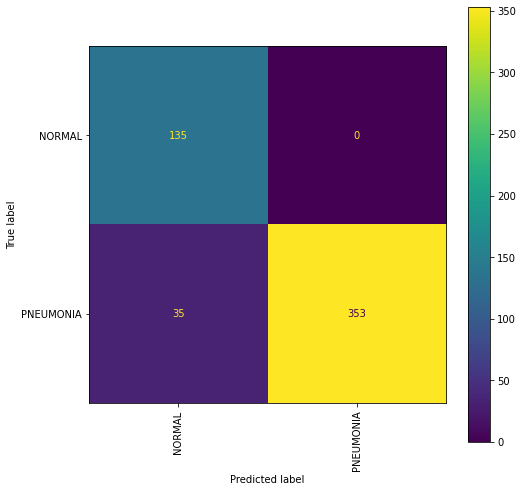

In [7]:
y_val = test_data.classes
y_pred = model.predict(test_data)
y_pred1 = ((y_pred > 0.5)+0).ravel()
cm = confusion_matrix(y_val,y_pred1)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['NORMAL', 'PNEUMONIA'])
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation=90)

In [8]:
print(classification_report(y_val,y_pred1))

              precision    recall  f1-score   support

           0       0.79      1.00      0.89       135
           1       1.00      0.91      0.95       388

    accuracy                           0.93       523
   macro avg       0.90      0.95      0.92       523
weighted avg       0.95      0.93      0.94       523



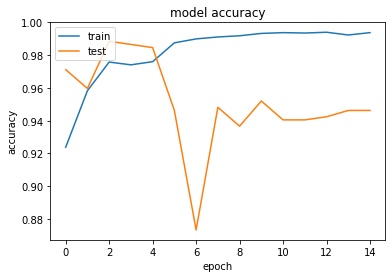

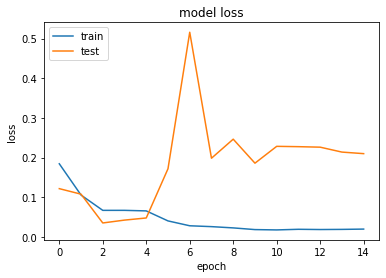

In [9]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()